<font color = green >

# TITANIC
</font>


In [1]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
import os

from sklearn.metrics import accuracy_score, log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

<font color = green >

# LOAD TITANIC_DATASET
</font>

---Missing values---
 PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64
---Unique values---
 PassengerId    1309
Survived          2
Pclass            3
Name           1307
Sex               2
Age              98
SibSp             7
Parch             8
Ticket          929
Fare            281
Cabin           186
Embarked          3
dtype: int64


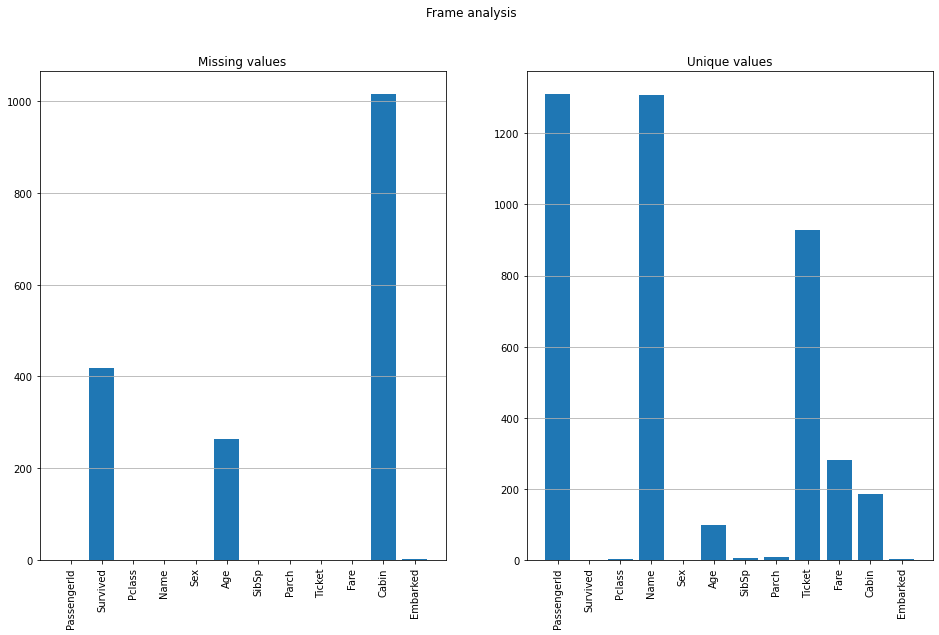

In [2]:
path = os.path.join(os.getcwd(), 'data')    
gender=train = pd.read_csv('./data/gender_submission.csv')
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
td = pd.concat([train, test], ignore_index=True, sort = False)

fig=plt.figure(figsize=[16,9])
#plt.plot(td.isnull().sum(), label='Is null')
plt.suptitle('Frame analysis')
plt.subplot(1,2,1)
plt.grid(axis='y')
plt.title("Missing values")
plt.bar(td.isnull().sum().index, td.isnull().sum().values)
plt.xticks(rotation=90)
#plt.show()
print('---Missing values---\n',td.isna().sum())

plt.subplot(1,2,2)
plt.grid(axis='y')
plt.title("Unique values")
plt.bar(td.nunique().index, td.nunique().values.astype(float))
plt.xticks(rotation=90)
print('---Unique values---\n',td.nunique())
plt.show()

<font color = green >

# ANALYSE
</font>

<AxesSubplot:title={'center':'Titanic included 64% of Male and 36% of Female'}>

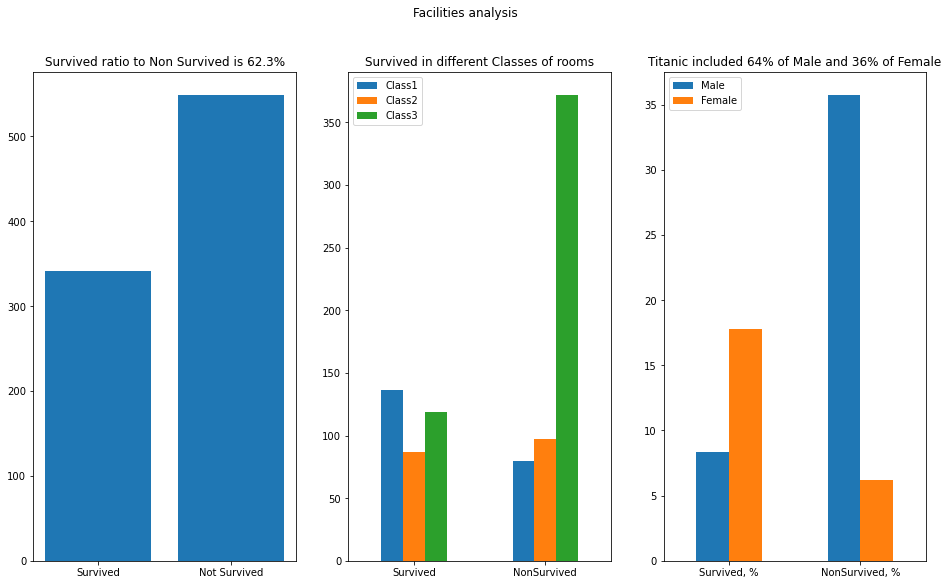

In [3]:
#------ Аналіз показників ------
fig=plt.figure(figsize=[16,9])

plt.suptitle('Facilities analysis') # --- Співвідношення виживших до потонувших
plt.subplot(131)
to_plot_arr=np.array([])
to_plot_arr=np.append(to_plot_arr,td[td.Survived==1].count().loc['Survived'])   #--Alive
to_plot_arr=np.append(to_plot_arr,td[td.Survived==0].count().loc['Survived'])   #--Dead
plt.bar(['Survived', 'Not Survived'],to_plot_arr)
plt.title(f'Survived ratio to Non Survived is {(to_plot_arr[0]/to_plot_arr[1]*100):.{1}f}%')


ax1=plt.subplot(132)        # --- Класи кают
to_plot_arr=pd.DataFrame([])
Survived=td[(td.Survived==1) & (td.Pclass==1)].count().loc['Pclass']
NonSurvived=td[(td.Survived==0) & (td.Pclass==1)].count().loc['Pclass']
to_plot_arr['Class1']=[Survived, NonSurvived]
Survived=td[(td.Survived==1) & (td.Pclass==2)].count().loc['Pclass']
NonSurvived=td[(td.Survived==0) & (td.Pclass==2)].count().loc['Pclass']
to_plot_arr['Class2']=[Survived, NonSurvived]
Survived=td[(td.Survived==1) & (td.Pclass==3)].count().loc['Pclass']
NonSurvived=td[(td.Survived==0) & (td.Pclass==3)].count().loc['Pclass']
to_plot_arr['Class3']=[Survived, NonSurvived]
to_plot_arr.index=['Survived', 'NonSurvived']
to_plot_arr.plot.bar(rot=0, subplots=False, ax=ax1)
plt.title('Survived in different Classes of rooms')

ax1=plt.subplot(133)        # --- Man/Woman
Male=td[(td.Sex=='male')].count().loc['Sex']
Female=td[(td.Sex=='female')].count().loc['Sex']
plt.title(f'Titanic included {100*Male/(Male+Female):.{0}f}% of Male and {100*Female/(Male+Female):.{0}f}% of Female')
to_plot_arr=pd.DataFrame([])
Survived=td[(td.Survived==1) & (td.Sex=='male')].count().loc['Sex']
NonSurvived=td[(td.Survived==0) & (td.Sex=='male')].count().loc['Sex']
to_plot_arr['Male']=[100*Survived/(Male+Female), 100*NonSurvived/(Male+Female)]
Survived=td[(td.Survived==1) & (td.Sex=='female')].count().loc['Sex']
NonSurvived=td[(td.Survived==0) & (td.Sex=='female')].count().loc['Sex']
to_plot_arr['Female']=[100*Survived/(Male+Female), 100*NonSurvived/(Male+Female)]
to_plot_arr.index=['Survived, %', 'NonSurvived, %']
to_plot_arr.plot.bar(rot=0, subplots=False, ax=ax1)

<font color = green >

# Filling the absent datas
</font>

In [4]:
td.Embarked.fillna(td.Embarked.mode()[0], inplace = True)   #--Filling the most Embarked data (City Southampton)

#td['Age_Range'] = pd.cut(td.Age, [0, 10, 20, 30, 40, 50, 60,70,80])
#---Age ---
td['Affiliation'] = td.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip()) #--selecting Mr./Miss. etc.
grouping = td.groupby(['Affiliation']).mean()
grouping.Age=round(grouping.Age)

def row_handler(row):
    if np.isnan(row['Age']):
        return grouping.loc[row.Affiliation].Age
    else:
        return row['Age']

td['Age'] = td.apply(row_handler, axis=1)

td['Age_Category'] = pd.cut(td['Age'], bins=[0, 10, 20, 45, 60, 80], labels=['Baby','Tinager','Meadle','Work','Old'])

td['Family'] = td.Parch + td.SibSp
td['Is_Alone'] = td.Family == 0

td.Fare.describe()
td.Fare.fillna(td.Fare.mean(), inplace = True)
td['Fare_Category'] = pd.cut(td['Fare'], bins=[-1,7.90,14.45,31.28,513], labels=['Low','Mid','High_Mid','High'])
#td.dropna(subset=['Fare_Category'], inplace=True)
td.info()

#td.drop(['Pclass', 'Fare','Cabin', 'Fare_Category','Name','Affiliation', 'Ticket','Embarked', 'Age_Category', 'SibSp', 'Parch', 'Age'], axis=1, inplace=True)
td.drop(['Fare','Cabin', 'Name','Affiliation', 'Ticket', 'SibSp', 'Parch', 'Age'], axis=1, inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   PassengerId    1309 non-null   int64   
 1   Survived       891 non-null    float64 
 2   Pclass         1309 non-null   int64   
 3   Name           1309 non-null   object  
 4   Sex            1309 non-null   object  
 5   Age            1309 non-null   float64 
 6   SibSp          1309 non-null   int64   
 7   Parch          1309 non-null   int64   
 8   Ticket         1309 non-null   object  
 9   Fare           1309 non-null   float64 
 10  Cabin          295 non-null    object  
 11  Embarked       1309 non-null   object  
 12  Affiliation    1309 non-null   object  
 13  Age_Category   1309 non-null   category
 14  Family         1309 non-null   int64   
 15  Is_Alone       1309 non-null   bool    
 16  Fare_Category  1309 non-null   category
dtypes: bool(1), category(2), float64(

<font color = green >

# Encoding
</font>

In [5]:
#======= Encoding=======
#td = pd.concat([td,pd.get_dummies(td.Age_Category, prefix="Age"), pd.get_dummies(td.Embarked, prefix="Emb", drop_first = True), pd.get_dummies(td.Fare_Category, prefix="Fare", drop_first = True), pd.get_dummies(td.Pclass, prefix="Class", drop_first = True)], axis=1)
td['Age_Category'] = LabelEncoder().fit_transform(td['Age_Category'])
td['Fare_Category'] = LabelEncoder().fit_transform(td['Fare_Category'])
td['Embarked'] = LabelEncoder().fit_transform(td['Embarked'])

td['Sex'] = LabelEncoder().fit_transform(td['Sex'])
td['Is_Alone'] = LabelEncoder().fit_transform(td['Is_Alone'])

<font color = green >

# Prediction
</font>

In [7]:
#======Prediction=====
#Data for prediction
pred_data = td[td.Survived.isnull()]
X_for_pred = pred_data.drop(['Survived'], axis = 1)

#Training data
train_data = td.dropna()
y_for_train = train_data['Survived']
X_for_train  = train_data.drop(['PassengerId', 'Survived'], axis = 1)

##Random forest
clf = RandomForestClassifier(criterion='entropy', 
                             n_estimators=1000,
                             min_samples_split=10,
                             min_samples_leaf=1,
                             max_features='auto',
                             oob_score=True,
                             random_state=2,
                             n_jobs=-1)
X_train, X_test, y_train, y_test = train_test_split(X_for_train, y_for_train, test_size=0.2)
clf.fit(X_train,  y_train)
print(f"RF Accuracy: {(clf.score(X_test, y_test)*100):.{2}f} %")

result_rf=cross_val_score(clf,X_train,y_train,cv=10,scoring='accuracy')
print('The cross validated score for Random forest is:',round(result_rf.mean()*100,2))
y_pred = cross_val_predict(clf,X_train,y_train,cv=10)
#plt.heatmap(confusion_matrix(y_train,y_pred),annot=True,fmt='3.0f',cmap="summer")
#plt.title('Confusion_matrix for RF', y=1.05, size=15)
confusion_matrix(y_train, y_pred)

result = clf.predict(X_for_pred.iloc[:,1:])
submission = pd.DataFrame({'PassengerId':X_for_pred.PassengerId,'Survived':result})
submission.Survived = submission.Survived.astype(int)
print(submission.shape)
filename = 'Titanic Predictions.csv'
submission.to_csv(filename,index=False)
print('Saved file: ' + filename)

RF Accuracy: 82.12 %
The cross validated score for Random forest is: 83.99
(418, 2)
Saved file: Titanic Predictions.csv
